<a href="https://colab.research.google.com/github/leejeongeun97/dataAnalysis/blob/main/2_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_05_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%88%98%EC%A7%91_OpenAPI_%EC%99%84%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 분석

## 5. OpenAPI를 이용한 데이터 수집

- <a href="#1)OpenAPI통한데이터수집">1) OpenAPI 통한 데이터 수집</a>
- <a href="#2)한글텍스트Cleansing">2) 한글 텍스트 Cleansing</a>
- <a href="#3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

### #그래프에서 한글사용하는 방법
- **(코랩에서)한글폰트 설치하기**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 코랩에서 위 코드를 실행시킨 후  반드시 코랩 메뉴: "런타임>런타임 다시 시작" 합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and direc

- **한글 폰트 지정하기**

In [1]:
# 코랩에서 한글 폰트 종류와 이름이 win과 다를 수 있다!!!
# 코랩: NanumGothic, 윈도우: Malgun Gothic
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'NanumBarunGothic',
                     'font.size': 12,
                     'figure.figsize': (6, 4),
                     'axes.unicode_minus':  False }) # 폰트 설정

---

### <a name="1)OpenAPI통한데이터수집">1) OpenAPI 통한 데이터 수집</a>

#### 1.네이버 OpenAPI 신청하기
* 네이버 검색(책, 뉴스, 쇼핑)
    - 네이버 OpenAPI 소개: https://developers.naver.com/products/intro/plan/
    - 개발 가이드 보기: https://developers.naver.com/docs/serviceapi/search/news
    - OpenAPI 신청하기: https://developers.naver.com/apps/#/register

#### 2.네이버 OpenAPI 사용하기
* 검색
    - 1.책 검색
    - 2.뉴스 검색
    - 3.쇼핑 검색

#### [실습] : 네이버 검색 API 사용하여 데이터 수집하기

In [2]:
# 정적 크롤링을 위한 requests 설치
!pip install requests

In [8]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd

now = datetime.datetime.now()
datas = []   #csv파일을 위한 변수

client_id = 'T5ia4Q8LyYzC65qPd9cd'          # 자신의 client_id
client_pw = 'Kg2eocMb6Z'          # 자신의 client_secret
PATH = '.'         # 수집 데이터 저장 폴더


#[CODE 1]
def get_RequestUrl(url):
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_pw)

    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
            return response.read().decode('utf-8')

    except Exception as e:
#         if response.getcode() == 400 and datas:
#             return None
        print(e)
        print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Error for URL : {url}" )
        return None


#[CODE 2]  네이버 검색 API
def get_NaverSearch(node, keyword, start, display):
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(keyword), start, display)

    url = base + node + parameters
    responseDecode = get_RequestUrl(url)   #[CODE 1]

    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)

#[CODE 3]
def get_PostData(node, post, jsonResult, cnt):
    if node == 'book':
        data = {'제목':post['title'],
                '저자':post['author'],
                '출판사':post['publisher'],
                '출간일':post['pubdate'],
                '링크':post['link'],
                '이미지':post['image']}
    elif node == 'news':
        data = {'제목':post['title'],
                '링크':post['originallink'],
                '내용':post['description']}
    elif node == 'shop':
        data = {'제목':post['title'],
                '브랜드':post['brand'],
                '제조사':post['maker'],
                '가격':post['lprice'],
                '이미지':post['image']}

    jsonResult.append(data)
    datas.append(data)

    return

#[CODE 0]
def main():
    global node, keyword

    nodeType = '''-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------'''
    print(nodeType)
    node = input('번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]')
    if node == '1': node = 'book'
    elif node == '2': node = 'news'
    elif node == '3': node = 'shop'
    else:
        node == '1'
        node = 'book'

    keyword = input(f'{node} 검색할 검색어를 입력하세요: ')

    display, cnt = 100, 0
    jsonResult = []
    jsonResponse = get_NaverSearch(node, keyword, 1, display)  #[CODE 2]
    total = jsonResponse['total']

    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):
        for post in jsonResponse['items']:
            cnt += 1
            get_PostData(node, post, jsonResult, cnt)  #[CODE 3]

        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = get_NaverSearch(node, keyword, start, total)
#     print(f'가져올 데이터 : {total} 건')

    # with open(f'{PATH}/naver_{node}_{keyword}', 'w', encoding='utf8') as outfile:
    #     jsonFile = json.dumps(jsonResult,  indent=4, sort_keys=True,  ensure_ascii=False)

    #     outfile.write(jsonFile)

    print("가져온 데이터 : %d 건" %(cnt))



    # csv 파일로 저장하기
    file = f'{PATH}/naver_{node}_{keyword}.csv'
    df = pd.DataFrame(datas)
    df.to_csv(file, index=False, encoding="utf-8-sig")
    print(f'{PATH}/naver_{node}_{keyword}.csv SAVED')
    return df

#-----------
# 시작
#-----------
df = main()
df

-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------
번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]1
book 검색할 검색어를 입력하세요: 파이썬
[2024년04월25일 03시25분17초] Url Request Success
HTTP Error 400: Bad Request
[2024년04월25일 03시25분17초] Error for URL : https://openapi.naver.com/v1/search/book.json?query=%ED%8C%8C%EC%9D%B4%EC%8D%AC&start=101&display=992
가져온 데이터 : 100 건
./naver_book_파이썬.csv SAVED


,제목,저자,출판사,출간일,링크,이미지
0,혼자 공부하는 파이썬 (1:1 과외하듯 배우는 프로그래밍 자습서),윤인성,한빛미디어,20220601,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_325076...
1,Do it! 점프 투 파이썬 (중학생도 첫날부터 실습하는 초고속 입문서),박응용,이지스퍼블리싱,20230615,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_403540...
2,코딩 자율학습 나도코딩의 파이썬 입문 (초보자 눈높이에 맞춘 친절한 프로그래밍 자습서),나도코딩,길벗,20230220,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_378282...
3,고객 니즈가 보이는 데이터 분석 with 파이썬 (트렌드 분석자가 알려주는 실무 데...,정인근,길벗,20240422,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_469557...
4,"실무로 통하는 인과추론 with 파이썬 (데이터 분석에서 정책 수립까지, 이론과 사...",마테우스 파쿠레,한빛미디어,20240305,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_460446...
...,...,...,...,...,...,...
95,코딩 없이(Low code) 클릭으로 한 번에 빅데이터 분석하기 (비주얼 파이썬으로),윤우제^이래중,ORP Press,20230531,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_406413...
96,두근두근 파이썬 (쉽고! 재밌고! 흥미로운 코딩 맛!),천인국,생능출판,20170116,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324646...
97,생활코딩! 파이썬 (가볍게 시작하여 유용하게 사용하는 생활코딩! Python),이고잉,범,20200323,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324443...
98,기초 정수론과 파이썬 (21세기 패러다임을 이끌 인재양성을 위한 기초 교양도서),최근배^최은선^박남제,홍릉,20231005,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_430546...




---



#### (24.2.29 서비스 종료됨)[실습] :  네이버 Papago API 사용하여 번역하기

In [ ]:
# import os
# import sys
# import urllib.request
# import datetime
# import json


# client_id = ''  # 자신의 파파고 NMT API ID
# client_pw = ''            # 자신의 파파고 NMT API PASSWORD

# news = []   #csv파일을 위한 변수

# #[CODE 1]
# def papago(prompt, lang=1):

#     encText = urllib.parse.quote(prompt)
#     if lang == 1 :
#         data = "source=ko&target=en&text=" + encText
#     else:
#         data = "source=en&target=ko&text=" + encText
#     url = "https://openapi.naver.com/v1/papago/n2mt"

#     req = urllib.request.Request(url)
#     req.add_header("X-Naver-Client-Id", client_id)
#     req.add_header("X-Naver-Client-Secret", client_pw)

#     try:
#         response = urllib.request.urlopen(req, data=data.encode("utf-8") )
#         if response.getcode() == 200:
#             print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
#             responseDecode = response.read().decode('utf-8')

#             if responseDecode == None:
#                 return None
#             else:
#                 return json.loads(responseDecode)

#     except Exception as e:
#         print(e)
#         print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
#         return None

# # 메인
# lang= int(input('[선택] 1:한글->영어, 2:영어->한글: '))
# txt =  '한글' if lang==1 else '영어'
# prompt= input(f'[번역] 변환할 문장을 입력하세요.[{txt}로 입력]: ')

# jsonResponse = papago(prompt, lang)  # 파파고 번역
# jsonResponse
# print('-'*50)
# print(f"[번역 결과] => {jsonResponse['message']['result']['translatedText']}")


-------------------------

### <a name="2)한글텍스트Cleansing">2) 한글 텍스트 Cleansing</a>

#### 1.라이브러리 설치

In [9]:
# 자연어처리 형태소 분석 및 토큰화
!pip install nltk

In [10]:
# (한글)자연어처리 형태소 분석 및 토큰화
# (WinOS에서는 konlpy를 사용하기 위해 JDK를 설치해야 오류가 없어 코랩에서 실행함)
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 22.4 MB/s eta 0:00:00


In [11]:
# html tag parsing을 위한 라이브러리
!pip install beautifulsoup4

In [12]:
# 사이킷런 CountVectorizer클래스 사용 : 단어 빈도수 추출
!pip install scikit-learn

#### 2.한글 테스트 자연어 처리(Text Cleansing)
- 앞에서 OpenAPI를 사용하여 뉴스 데이터를 가져온 뒤에 아래 코트를 실행시키도록 한다.


In [21]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import konlpy
import nltk

def clean_korean_documents(documents):
    #텍스트 정제 (HTML 태그 제거)
    for i, document in enumerate(documents):
        document = BeautifulSoup(document, 'html.parser').text
        documents[i] = document

    #텍스트 정제 (특수기호 제거)
    for i, document in enumerate(documents):
        document = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', document) #특수기호 제거, 정규 표현식
        documents[i] = document

    #텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    #텍스트 정제 (불용어 제거)
    df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    df[0] = df[0].apply(lambda x: x.strip())
    stopwords = df[0].to_numpy()
    nltk.download('punkt')
    for i, document in enumerate(documents):
        clean_words = []
        for word in nltk.tokenize.word_tokenize(document):
            if word not in stopwords: #불용어 제거
                clean_words.append(word)
        documents[i] = ' '.join(clean_words)

    return documents


def clean_target_feature(data):
    x_data = data.to_list()
    return clean_korean_documents(x_data)



# ---------------------
# 1.클린징할 파일 가져오기
#file = f'{PATH}/naver_{node}_{keyword}.csv'  # 앞에서 만들어진 파일 사용하기
file = './naver_news_눈물의여왕.csv'
df = pd.read_csv(file)

# 2.클린징할 컬럼 선택해서 클린징하기
# (앞 OpenAPI검색에서 2.news 검색을 한 후 실행하기)
df['제목'] = clean_target_feature(df['제목'])  # 기사 제목
df['내용'] = clean_target_feature(df['내용'])  # 기사 내용

# 3.클린징 결과 csv 파일로 저장하기
temp=file.replace('.csv','')
file = f'{temp}_clean.csv'
df.to_csv(file, index=False, encoding="utf-8-sig")
print(f'{file} SAVED')

df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


./naver_news_눈물의여왕_clean.csv SAVED


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,제목,링크,내용
0,김수현 수십 기자 상대 하다 프로 여유,http://www.osen.co.kr/article/G1112323763,김수현 토일 드라마 눈물 여왕 백현우 역할 여러 면 빼어나다 완벽하다 남성 연기 하...
1,포토 눈물 여왕 김수현,https://www.newdaily.co.kr/site/data/html/2024...,뉴데일리 정상윤 기자 배우 김수현 오전 서울 성동구 성수동 비컨 스튜디오 열리다 미...
2,포토 김수현 민준,http://enews.imbc.com/News/RetrieveNewsInfo/41...,눈물 여왕 화제 모으다 있다 김수현 여전하다 매력 뽐내다 배우 김수현 오전 서울 성...
3,넷플릭스 드라마 트렌드 지수 순위 위 눈물 여왕 달러 아스 달 연대기 뒤,https://www.stardailynews.co.kr/news/articleVi...,눈물 여왕 공개 되다 랭 키파 이의 넷플릭스 드라마 트렌드 지수 분석 결과 위 오르...
4,이미숙 안방 극장 스크린 접수 눈물 여왕 신드롬 잇다,https://www.tvreport.co.kr/star/article/806758/,역대 드라마 위 올라서다 눈물 여왕 강렬하다 카리스마 시청자 사로자다 배우 이미숙 ...


#### 3.워드 클라우드 만들기

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# 말뭉치를 토큰화하여 빈도수 가져오기
def get_wordTokenCount(corpus):
    from sklearn.feature_extraction.text import CountVectorizer

    # 말뭉치를 토큰화하기
    vect = CountVectorizer().fit(corpus)
    count = vect.transform(corpus).toarray().sum(axis=0)

    # 토큰 빈도수로 정렬하고 토큰명 추출
    idx = np.argsort(-count)  # 내림 정렬하여 인덱스 반환: 토큰의 인덱스
    count = count[idx]        # 토큰의 빈도수
    feature_name = np.array(vect.get_feature_names_out())[idx]  # 토큰값

    # 빈도수 많은 순서대로 토큰명 10개만 출력
    print(list(zip(feature_name, count))[:10])

    return feature_name, count


# 단어(토큰) 빈도수 막대 그래프 그리기
def draw_wordTokenCountGraph(data, freq):
    plt.bar(data, freq)
    plt.grid()
    plt.show()

    # 그래프 그림 저장히기
    plt.savefig(f'./token_bar_graph.png')

# 워드클라우드 만들기
def make_wordcloud(feature_name, count):
    # 한글 폰트 경로를 설정
    font_path = 'NanumGothic'  #/usr/share/fonts/truetype/nanum/NanumGothic.ttf  #코랩
    #font_path = 'malgun'  # C:/Windows/Fonts/                                  #window

    # (토큰명, 빈도수) 딕셔너리 타입으로 변환
    data = dict(zip(feature_name, count))

    # 워드클라우드로 그래프로 시각화
    wc = WordCloud(width = 1000, height = 600, background_color="black", font_path=font_path)
    plt.imshow(wc.generate_from_frequencies(data)) #딕셔너리
    plt.axis("off")
    plt.show()

    # 이미지 파일로 저장하기
    wc.to_file(f'./워드클라우드.png')


In [16]:
!pip install wordcloud

[('김수현', 78), ('눈물', 51), ('여왕', 41), ('포토', 28), ('사진', 26), ('백현우', 13), ('이미숙', 8), ('설계자', 7), ('하트', 7), ('스크린', 7)]


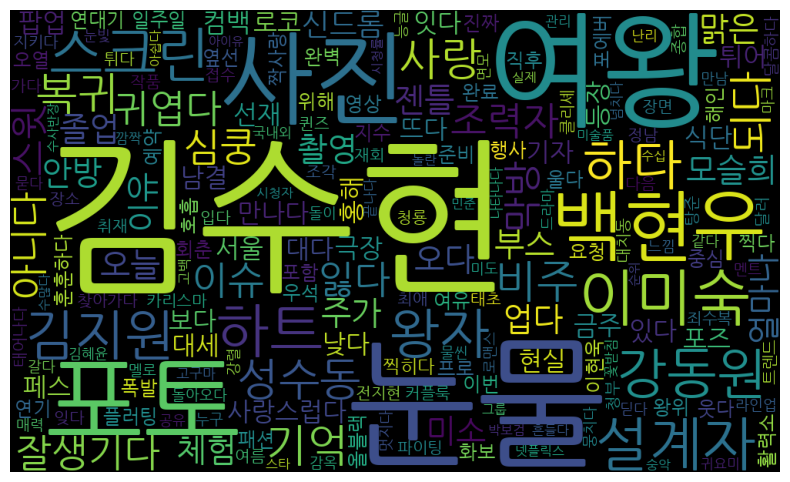

In [19]:
import pandas as pd

# 1.텍스트 말뭉치(corpus) 데이터 지정하기
corpus = df['제목'].to_list()
# print(corpus)

# 2.말뭉치를 토큰화하여 빈도수 가져오기
feature_name, count = get_wordTokenCount(corpus)

# 3.단어(토큰) 빈도수 막대 그래프 그리기(상위 10개)
# draw_wordTokenCountGraph(feature_name[:10], count[:10])

# 3.워드 클라우드 만들기
make_wordcloud(feature_name, count)



---



### <a name="3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

#### 1.웹 이미지 화면에 출력하기

In [22]:
from IPython.display import Image
Image(url='https://shopping-phinf.pstatic.net/main_3815224/38152244716.20230516165404.jpg')

#### 2.웹 이미지 파일로 저장하기

In [25]:
import requests
from io import BytesIO
from PIL import Image

# 다운받을 이미지 url
urls = [
    "https://shopping-phinf.pstatic.net/main_3815224/38152244716.20230516165404.jpg",
    "https://shopping-phinf.pstatic.net/main_3726611/37266116619.20230119071117.jpg"
]
# 파일로 저장하기
for idx, url in enumerate(urls):
    res = requests.get(url)                   # url 요청
    #print(res.content)
    img = Image.open(BytesIO(res.content))    # 응답결과(res.content)바이트파일 이미지 파일로 오픈
    img.save(f'./testimg_{idx}.png', 'png')   # 'png'이미지로(만) 저장

b'\xff\xd8\xff\xe1\x00\xa4Exif\x00\x00II*\x00\x08\x00\x00\x00\x05\x00\x12\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00J\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00R\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00i\x87\x04\x00\x01\x00\x00\x00Z\x00\x00\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x90\x07\x00\x04\x00\x00\x000210\x00\xa0\x07\x00\x04\x00\x00\x000100\x01\xa0\x03\x00\x01\x00\x00\x00\xff\xff\x00\x00\x02\xa0\x04\x00\x01\x00\x00\x00\xca\x01\x00\x00\x03\xa0\x04\x00\x01\x00\x00\x00|\x02\x00\x00\x00\x00\x00\x00\xff\xe1\x04\x1chttp://ns.adobe.com/xap/1.0/\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?> <x:xmpmeta xmlns:x="adobe:ns:meta/" x:xmptk="Adobe XMP Core 5.3-c011 66.145661, 2012/02/06-14:56:27        "> <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"> <rdf:Description rdf:about="" xmlns:xmpMM="http://ns.adobe.com/xap/1.0/mm/" xmlns:stRef="http://ns.adobe.com

#### [실습] : 웹 이미지 수집하기
- 앞에서 저장한 쇼핑 목록에 있는 URL을 이용하여 이미지 저장하기

In [27]:
# 이미지 다운로드 하기
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import time
import os

# 자신에게 맞게 폴더/파일 위치 정보를 수정한다.
FILE = f'./naver_shop_두유.csv'  # 앞에서 자신이 검색한 쇼핑 파일
ImgFolder = f'./download/'      # 다운받을 이미지 폴더
MAX = 10                              # 이미지 파일 다운로드 건수

def getImageUrl(file):
    print(f'읽은 파일명: {file}')
    df = pd.read_csv(file, encoding='utf-8') # 이미지가 있는 쇼핑 파일 불러오기
    return df['이미지'].to_list()

def createDirectory(directory): # 다운받을 이미지 폴더 만들기
    try:
        if not os.path.exists(directory):
            print(f'{directory} 폴더가 생성되었습니다.')
            os.makedirs(directory)
        print(f'이미지 폴더 위치 : {directory}')
    except OSError:
        print("Error: Failed to create the directory.")

def downloadImageFile(urls, imgfolder):
    start = time.time()             # 이미지 다운로드 속도 time check
    for idx, url in enumerate(urls):
        if idx == MAX:
            break  # MAX 건수만 처리하기
        res = requests.get(url)     # request.get 요청
#         print(f'[{idx+1:2>}][{time.time() - start}] : {url}')  # 이미지 다운로드 시간 체크
        print(f'[{idx+1:0>2}] : {url}')  # 이미지 다운로드 시간 체크
        img = Image.open(BytesIO(res.content))  #Img open
        img.save(f'{imgfolder}testimage_{idx}.png', 'png')
    return idx


urls = getImageUrl(FILE)                # 이미지 URL 목록 가져오기
createDirectory(ImgFolder)              # 다운받을 이미지 폴더 만들기
totalcnt = downloadImageFile(urls, ImgFolder)      # 이미지 다운로드하기
print(f'총 다운로드 건수: {totalcnt}')


읽은 파일명: ./naver_shop_두유.csv
이미지 폴더 위치 : ./download/
[01] : https://shopping-phinf.pstatic.net/main_5670861/5670861081.20180529160826.jpg
[02] : https://shopping-phinf.pstatic.net/main_3050069/30500695618.20220112115957.jpg
[03] : https://shopping-phinf.pstatic.net/main_3095814/30958140618.20230621135429.jpg
[04] : https://shopping-phinf.pstatic.net/main_1183825/11838251358.20230309150319.jpg
[05] : https://shopping-phinf.pstatic.net/main_5682952/5682952921.20220221180643.jpg
[06] : https://shopping-phinf.pstatic.net/main_2730107/27301074522.20220315142353.jpg
[07] : https://shopping-phinf.pstatic.net/main_3348673/33486735618.20220714103102.jpg
[08] : https://shopping-phinf.pstatic.net/main_8681591/8681591061.20220620022632.jpg
[09] : https://shopping-phinf.pstatic.net/main_2283948/22839485428.20200512173500.jpg
[10] : https://shopping-phinf.pstatic.net/main_2149009/21490091246.20191210162725.jpg
총 다운로드 건수: 10


---------------------------

끝!